In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3UU2LGdKxkoGySjm4kBn")
project = rf.workspace("seva-at1qy").project("rust-and-scrach")
version = project.version(1)
dataset = version.download("multiclass")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# %% [markdown]
# Multi-class pipeline (Roboflow -> PyTorch)
# Эта тетрадка ожидает, что в папке (например "/content/Rust-and-Scrach-1/train")
# есть файл "_classes.csv" и файлы изображений, как у Roboflow-export multiclass.

# %%
# 1) Импорты и устройство
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


In [7]:
import os

base_dir = dataset.location
print("Base dir:", base_dir)
print("Train:", os.listdir(os.path.join(base_dir, "train")))
print("Valid:", os.listdir(os.path.join(base_dir, "valid")))


Base dir: /content/Rust-and-Scrach-1
Train: ['01d9edbaafadf98722d310f086fd5b80_jpg.rf.5100f1ed0b9879111b189d04fd4f533e.jpg', '36ce2f6s-1920_jpg.rf.bb8693ad297c1731d16479cde1a09f76.jpg', 'CMmr-R5T4Qv_clTRinNsds2U0w4-480_jpg.rf.c327174e64dfcda842539e798501b5bc.jpg', '1200x900-1-_jpg.rf.d1c35d688b9c1c496db28c8d888694f9.jpg', '528b6e71348a20364752d2cc213d101d_jpg.rf.98476b9859bfdc476c31aaa0a337644e.jpg', '07555a580f25e8d70ae0b9e1b1bbcd4e_jpg.rf.b9fcd05c92d64cd39f28bc3a0c44a0d9.jpg', 'image_12_02_15_12_05_2_jpeg.rf.f52d467c6d64d4c780e30a0f32e30082.jpg', '481ad765e60d63cad245b1006c7a8f20_jpeg.rf.ee82f42833f2eae0283cc21d04120caf.jpg', 'iStock-174860744_jpg.rf.95e2ac920faf5489a76913e846127a4e.jpg', '1200x900-6-_jpg.rf.5d9dcdc388995c7c6e4afd79c4544771.jpg', '1200x900-5-_jpg.rf.ea39a6ecd0be2472a097e6d39fcba675.jpg', '2773635206_2f2c812a69_k_jpg.rf.1cb6a817c36e9945bbe820408c06d32c.jpg', 'k3yiW5Ox_jpg.rf.7c50e4b3b75fed557d555d9e921129ea.jpg', 'b0ccd52c7c31866767ef42783b923a39_jpeg.rf.aed37cb3f0ebe

In [8]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class RoboflowDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        # читаем CSV с разметкой
        self.df = pd.read_csv(os.path.join(folder, "_classes.csv"))
        # убеждаемся, что файл называется правильно
        print("Пример разметки:", self.df.head())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.folder, row["filename"])
        image = Image.open(img_path).convert("RGB")
        label = row["class"]   # или 'label', посмотри в _classes.csv как называется колонка
        if self.transform:
            image = self.transform(image)
        return image, label

# Трансформации
transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = RoboflowDataset(os.path.join(base_dir, "train"), transform=transform)
valid_ds = RoboflowDataset(os.path.join(base_dir, "valid"), transform=transform)
test_ds  = RoboflowDataset(os.path.join(base_dir, "test"),  transform=transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)



Пример разметки:                                             filename  car  dunt  rust  scracth
0  1200x900-22-_jpg.rf.f9f3f9d248a3734daf55b8e467...    1     0     0        0
1  czarapina-na-mashine-do-metalla_jpg.rf.667730a...    0     0     0        1
2  1200x900n_jpg.rf.7ecd9e24e775e860db169f62d56a9...    1     0     0        0
3  CMmr-R5T4Qv_clTRinNsds2U0w4-480_jpg.rf.c327174...    0     1     0        1
4  scale_1200_jpeg.rf.060c67139dd7f16f1cf410ccc20...    0     1     0        0
Пример разметки:                                             filename  car  dunt  rust  scracth
0  1200x900-2-_jpg.rf.e3b13aef3146d807042e1831a5c...    1     1     0        0
1  1200x900-13-_jpg.rf.d11bc73658e4ae3669ddf01c5d...    1     0     0        0
2  mGLIbRvb_jpg.rf.89a91a3fe2d4bfcddd82cc8a762dd3...    1     0     0        0
3  245bcc6s-1920_jpg.rf.b0b5abb249ad4c5332cb2b5c2...    0     0     0        1
4  a26946beaf3973c94fd4413f9c8291ff_jpeg.rf.06342...    0     0     1        0
Пример разметки:  

In [9]:
import pandas as pd

df = pd.read_csv("/content/Rust-and-Scrach-1/train/_classes.csv")
print(df.head())

print(df.columns)
print(df.filename[1])



                                            filename  car  dunt  rust  scracth
0  1200x900-22-_jpg.rf.f9f3f9d248a3734daf55b8e467...    1     0     0        0
1  czarapina-na-mashine-do-metalla_jpg.rf.667730a...    0     0     0        1
2  1200x900n_jpg.rf.7ecd9e24e775e860db169f62d56a9...    1     0     0        0
3  CMmr-R5T4Qv_clTRinNsds2U0w4-480_jpg.rf.c327174...    0     1     0        1
4  scale_1200_jpeg.rf.060c67139dd7f16f1cf410ccc20...    0     1     0        0
Index(['filename', 'car', 'dunt', 'rust', 'scracth'], dtype='object')
czarapina-na-mashine-do-metalla_jpg.rf.667730af27708f38cd4021480e6df658.jpg


In [10]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms

class RoboflowDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        # читаем CSV
        self.df = pd.read_csv(os.path.join(folder, "_classes.csv"))
        print("Колонки в CSV:", self.df.columns.tolist())

        # список классов = все кроме "filename"
        self.classes = [c for c in self.df.columns if c != "filename"]
        print("Найдены классы:", self.classes)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.folder, row["filename"])
        image = Image.open(img_path).convert("RGB")

        # вектор one-hot
        labels = torch.tensor(row[self.classes].values.astype("float32"))

        if self.transform:
            image = self.transform(image)
        return image, labels


# Трансформации
transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

base_dir = "/content/Rust-and-Scrach-1"

train_ds = RoboflowDataset(os.path.join(base_dir, "train"), transform=transform)
valid_ds = RoboflowDataset(os.path.join(base_dir, "valid"), transform=transform)
test_ds  = RoboflowDataset(os.path.join(base_dir, "test"),  transform=transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl  = DataLoader(test_ds,  batch_size=16)

num_classes = len(train_ds.classes)
print("Всего классов:", num_classes)


Колонки в CSV: ['filename', 'car', 'dunt', 'rust', 'scracth']
Найдены классы: ['car', 'dunt', 'rust', 'scracth']
Колонки в CSV: ['filename', 'car', 'dunt', 'rust', 'scracth']
Найдены классы: ['car', 'dunt', 'rust', 'scracth']
Колонки в CSV: ['filename', 'car', 'dunt', 'rust', 'scracth']
Найдены классы: ['car', 'dunt', 'rust', 'scracth']
Всего классов: 4


In [11]:
import torch.nn as nn
import torch
from torchvision import models

# Загружаем предобученную ResNet18
model = models.resnet18(pretrained=True)

# Замораживаем фичи (можно не замораживать, если датасет большой)
for param in model.parameters():
    param.requires_grad = False

# Меняем последний слой
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Лосс и оптимизатор
criterion = nn.BCEWithLogitsLoss()  # multi-label
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [12]:
def train_model(model, train_dl, valid_dl, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Валидация
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, labels in valid_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dl):.4f}, Valid Loss: {valid_loss/len(valid_dl):.4f}")

    return model

# Запуск
model = train_model(model, train_dl, valid_dl, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 0.6717, Valid Loss: 0.5558
Epoch 2/10, Train Loss: 0.6000, Valid Loss: 0.4775
Epoch 3/10, Train Loss: 0.5468, Valid Loss: 0.4734
Epoch 4/10, Train Loss: 0.5114, Valid Loss: 0.4703
Epoch 5/10, Train Loss: 0.4724, Valid Loss: 0.4556
Epoch 6/10, Train Loss: 0.4393, Valid Loss: 0.4149
Epoch 7/10, Train Loss: 0.4324, Valid Loss: 0.3513
Epoch 8/10, Train Loss: 0.3976, Valid Loss: 0.3415
Epoch 9/10, Train Loss: 0.3687, Valid Loss: 0.3495
Epoch 10/10, Train Loss: 0.3665, Valid Loss: 0.3441


In [13]:
from sklearn.metrics import f1_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # бинаризация
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("F1 Score (micro):", f1_score(all_labels, all_preds, average="micro"))
print("F1 Score (macro):", f1_score(all_labels, all_preds, average="macro"))


F1 Score (micro): 0.7368421052631579
F1 Score (macro): 0.625


In [14]:
from PIL import Image

def predict_image(path, model, transform, classes):
    model.eval()
    img = Image.open(path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    results = {cls: float(probs[i]) for i, cls in enumerate(classes)}
    return results

# Пример
print(predict_image("/content/Rust-and-Scrach-1/valid/1200x900-13-_jpg.rf.d11bc73658e4ae3669ddf01c5decaa62.jpg", model, transform, train_ds.classes))


{'car': 0.6566498279571533, 'dunt': 0.3195279836654663, 'rust': 0.09933939576148987, 'scracth': 0.3128485679626465}


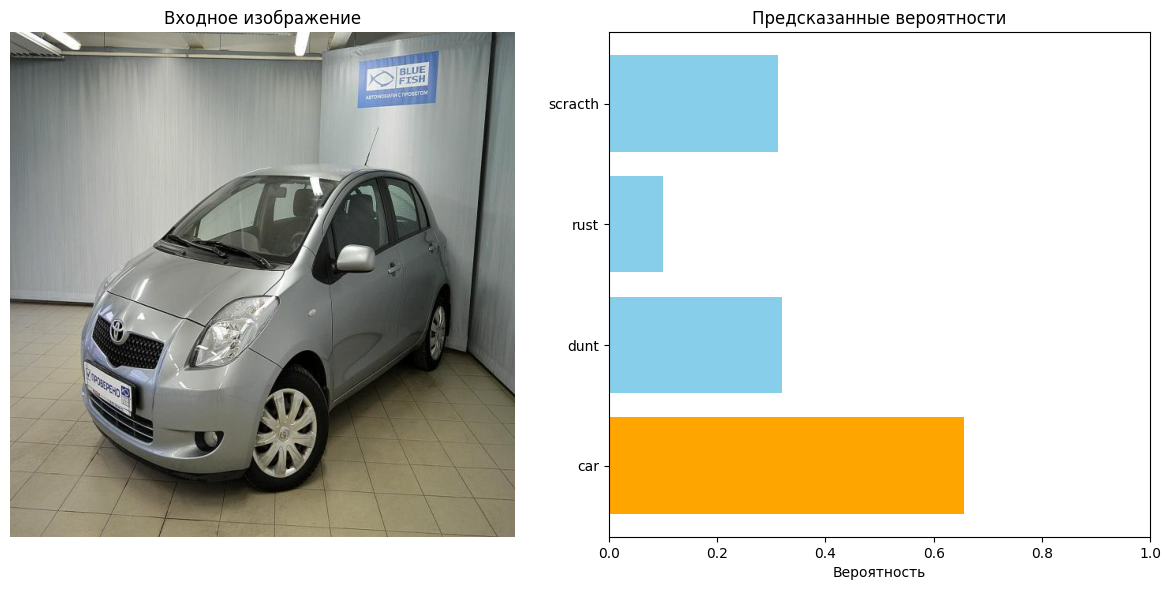

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(path, model, transform, classes):
    model.eval()
    img = Image.open(path).convert("RGB")

    # Преобразуем для модели
    tensor_img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor_img)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Картинка
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Входное изображение")

    # Барчарт
    ax2.barh(classes, probs, color="skyblue")
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Вероятность")
    ax2.set_title("Предсказанные вероятности")

    # Выделим лучший класс
    best_idx = np.argmax(probs)
    ax2.barh(classes[best_idx], probs[best_idx], color="orange")

    plt.tight_layout()
    plt.show()


# Пример
visualize_prediction(
    "/content/Rust-and-Scrach-1/valid/1200x900-13-_jpg.rf.d11bc73658e4ae3669ddf01c5decaa62.jpg",
    model, transform, train_ds.classes
)


In [16]:
from PIL import Image

def predict_image(path, model, transform, classes):
    model.eval()
    img = Image.open(path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    results = {cls: float(probs[i]) for i, cls in enumerate(classes)}
    return results

# Пример
print(predict_image("/content/Rust-and-Scrach-1/train/01d9edbaafadf98722d310f086fd5b80_jpg.rf.5100f1ed0b9879111b189d04fd4f533e.jpg", model, transform, train_ds.classes))


{'car': 0.670711100101471, 'dunt': 0.2636323571205139, 'rust': 0.05293450504541397, 'scracth': 0.2068503201007843}


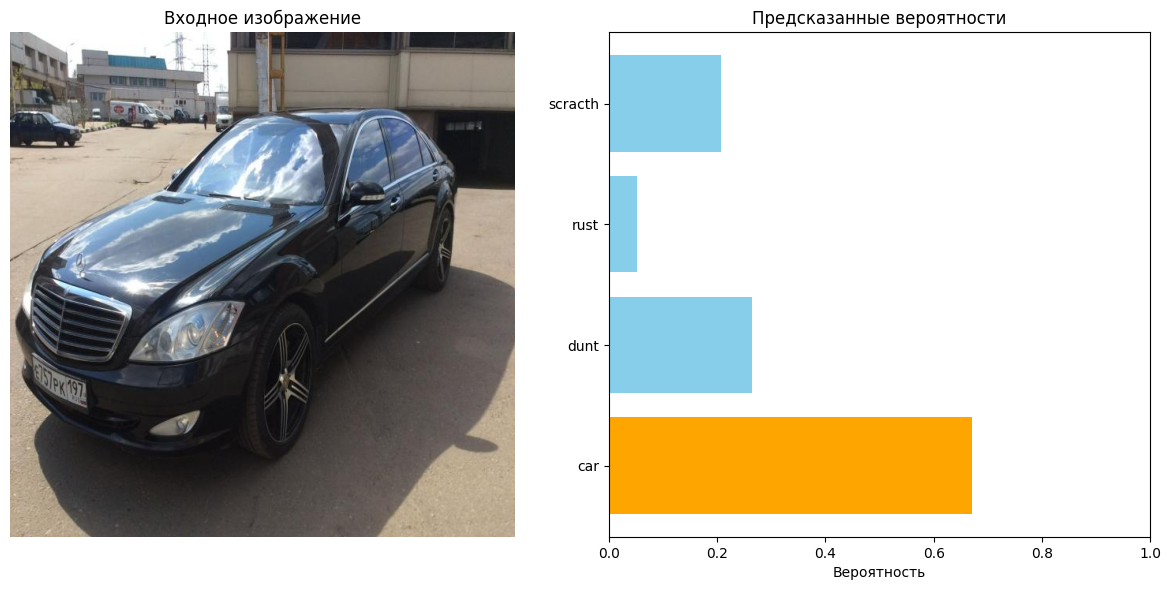

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(path, model, transform, classes):
    model.eval()
    img = Image.open(path).convert("RGB")

    # Преобразуем для модели
    tensor_img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor_img)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Картинка
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Входное изображение")

    # Барчарт
    ax2.barh(classes, probs, color="skyblue")
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Вероятность")
    ax2.set_title("Предсказанные вероятности")

    # Выделим лучший класс
    best_idx = np.argmax(probs)
    ax2.barh(classes[best_idx], probs[best_idx], color="orange")

    plt.tight_layout()
    plt.show()


# Пример
visualize_prediction(
    "/content/Rust-and-Scrach-1/train/01d9edbaafadf98722d310f086fd5b80_jpg.rf.5100f1ed0b9879111b189d04fd4f533e.jpg",
    model, transform, train_ds.classes
)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np

# 1) Fine-tuning: размораживаем layer4 + fc
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# 2) Балансировка: считаем веса для классов
# суммируем количество примеров для каждого класса в train_ds
class_counts = np.array(train_ds.df[train_ds.classes].sum().values)
total = class_counts.sum()
pos_weights = torch.tensor(total / class_counts, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

# ==========================
# Функции обучения/валидации
# ==========================
def evaluate(model, loader, threshold=0.5):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > threshold).astype(int)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
    micro = f1_score(all_labels, all_preds, average="micro")
    macro = f1_score(all_labels, all_preds, average="macro")
    return micro, macro

def train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, epochs=10):
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Валидация с F1
        micro, macro = evaluate(model, valid_dl, threshold=0.5)
        avg_f1 = (micro + macro) / 2

        scheduler.step(avg_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dl):.4f}, "
              f"Val Micro-F1: {micro:.4f}, Val Macro-F1: {macro:.4f}")

        # Сохраняем лучшую модель
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            torch.save(model.state_dict(), "best_f1_model.pth")
            print("💾 Лучшая модель сохранена")
    return model

# Запуск
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, epochs=15)


Epoch 1/15, Train Loss: 0.8111, Val Micro-F1: 0.7925, Val Macro-F1: 0.7538
💾 Лучшая модель сохранена
Epoch 2/15, Train Loss: 0.3482, Val Micro-F1: 0.7636, Val Macro-F1: 0.6913
Epoch 3/15, Train Loss: 0.2081, Val Micro-F1: 0.7778, Val Macro-F1: 0.7042
Epoch 4/15, Train Loss: 0.1747, Val Micro-F1: 0.8077, Val Macro-F1: 0.7667
💾 Лучшая модель сохранена
Epoch 5/15, Train Loss: 0.1220, Val Micro-F1: 0.8077, Val Macro-F1: 0.7667
Epoch 6/15, Train Loss: 0.1155, Val Micro-F1: 0.8077, Val Macro-F1: 0.7667
Epoch 7/15, Train Loss: 0.0671, Val Micro-F1: 0.8400, Val Macro-F1: 0.7917
💾 Лучшая модель сохранена
Epoch 8/15, Train Loss: 0.0735, Val Micro-F1: 0.8400, Val Macro-F1: 0.7917
Epoch 9/15, Train Loss: 0.0483, Val Micro-F1: 0.8400, Val Macro-F1: 0.7917
Epoch 10/15, Train Loss: 0.0452, Val Micro-F1: 0.8400, Val Macro-F1: 0.7917
Epoch 11/15, Train Loss: 0.0616, Val Micro-F1: 0.8400, Val Macro-F1: 0.7917
Epoch 12/15, Train Loss: 0.0393, Val Micro-F1: 0.8511, Val Macro-F1: 0.7667
Epoch 13/15, Train 

In [20]:
# Загружаем лучшую модель
model.load_state_dict(torch.load("best_f1_model.pth"))
model.eval()

thresholds = np.linspace(0.1, 0.9, 9)
best_thr, best_macro = 0.5, 0

for thr in thresholds:
    micro, macro = evaluate(model, valid_dl, threshold=thr)
    print(f"Threshold={thr:.1f} | Micro-F1={micro:.4f} | Macro-F1={macro:.4f}")
    if macro > best_macro:
        best_macro, best_thr = macro, thr

print(f"🔎 Лучший threshold={best_thr:.2f}, Macro-F1={best_macro:.4f}")


Threshold=0.1 | Micro-F1=0.6774 | Macro-F1=0.6370
Threshold=0.2 | Micro-F1=0.7241 | Macro-F1=0.6613
Threshold=0.3 | Micro-F1=0.7925 | Macro-F1=0.7576
Threshold=0.4 | Micro-F1=0.8077 | Macro-F1=0.7667
Threshold=0.5 | Micro-F1=0.8400 | Macro-F1=0.7917
Threshold=0.6 | Micro-F1=0.8333 | Macro-F1=0.7500
Threshold=0.7 | Micro-F1=0.8333 | Macro-F1=0.7500
Threshold=0.8 | Micro-F1=0.8696 | Macro-F1=0.7818
Threshold=0.9 | Micro-F1=0.8500 | Macro-F1=0.6375
🔎 Лучший threshold=0.50, Macro-F1=0.7917


In [22]:
# зафиксировать лучший парог
best_threshold = 0.5  # мы нашли его через перебор

In [25]:
# Протестировать на test-наборе
micro, macro = evaluate(model, test_dl, threshold=best_threshold)
print(f"Test Micro-F1={micro:.4f}, Macro-F1={macro:.4f}")


Test Micro-F1=0.9167, Macro-F1=0.9143


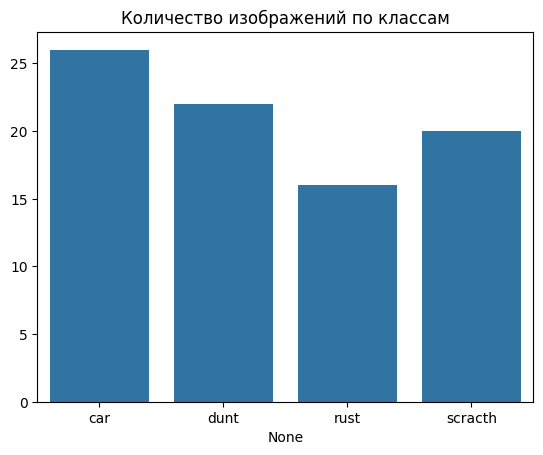

In [26]:
import seaborn as sns

class_counts = train_ds.df[train_ds.classes].sum()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Количество изображений по классам")
plt.show()


📊 Итоговые метрики:
Accuracy: 0.8000
Micro - Precision: 0.8462, Recall: 1.0000, F1: 0.9167
Macro - Precision: 0.8542, Recall: 1.0000, F1: 0.9143


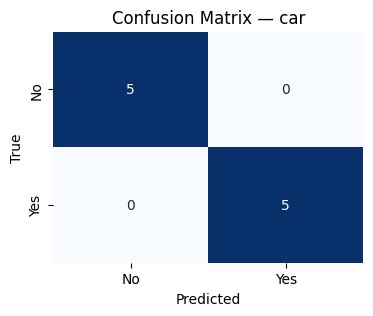

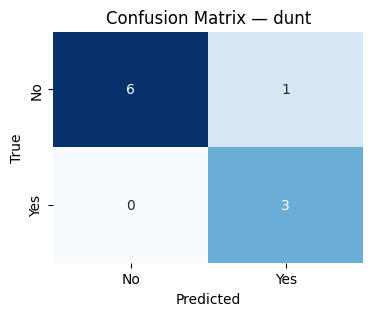

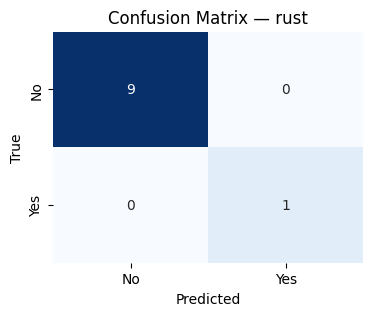

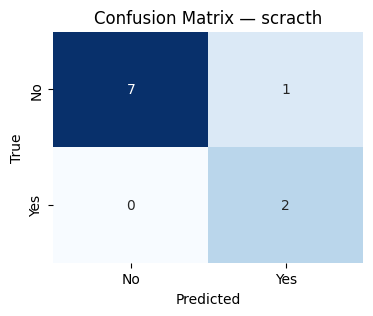

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Предсказания на тесте ---
model.load_state_dict(torch.load("best_f1_model.pth"))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)   # используем threshold=0.5
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# --- Метрики ---
accuracy = accuracy_score(all_labels, all_preds)
precision_micro = precision_score(all_labels, all_preds, average="micro", zero_division=0)
recall_micro = recall_score(all_labels, all_preds, average="micro", zero_division=0)
f1_micro = f1_score(all_labels, all_preds, average="micro")

precision_macro = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average="macro")

print("📊 Итоговые метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Micro - Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")
print(f"Macro - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")

# --- Confusion Matrix для каждого класса ---
# Для multi-label считаем confusion matrix отдельно по каждому классу
for i, cls in enumerate(train_ds.classes):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix — {cls}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


True No / Pred No (5) — модель правильно сказала «Нет машины» 5 раз.

True No / Pred Yes (0) — модель сказала «Есть машина», но на самом деле её не было → ошибок нет.

True Yes / Pred No (0) — модель сказала «Нет машины», но на самом деле машина была → ошибок нет.

True Yes / Pred Yes (5) — модель правильно сказала «Есть машина» 5 раз.
